In [234]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import matplotlib.colors as colors
import matplotlib.cm as cm  # Para usar un colormap
from scipy.interpolate import interp1d


In [139]:
pars = np.loadtxt('/home/jovyan/Data/Parameters/IllustrisTNG/CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt', skiprows=1, usecols = (1,2,3,4,5,6))
# pars[:,0] = Omega_m
# pars[:,1] = sigma_8
# pars[:,2] = A_SN1
# pars[:,3] = A_AGN1
# pars[:,4] = A_SN2
# pars[:,5] = A_AGN2

In [141]:
pars.shape

(1000, 6)

In [200]:
R_bins = np.geomspace(1,100,20)

def analyse_sim(simu):
    f_snapshot = '/home/jovyan/Data/Sims/' + simu + '/snapshot_090.hdf5'
    f_catalog  = '/home/jovyan/Data/FOF_Subfind/' + simu + '/groups_090.hdf5'

    catalog = h5py.File(f_catalog, 'r')
    snapshot = h5py.File(f_snapshot, 'r')
    h = snap['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
    mass_dm = snap['Header'].attrs[u'MassTable'][1]*1e10/h

    # for the subhalos lets read their position, velocity
    pos_sh = catalog['Subhalo/SubhaloPos'][:]/1e3        #Mpc/h
    vel_sh = catalog['Subhalo/SubhaloVel'][:]            #km/s
    Nsub_h = catalog['Group/GroupNsubs'][:]
    lentype_h = catalog['Group/GroupLenType'][:]
    lentype_sh = catalog['Subhalo/SubhaloLenType'][:]
    index_h_sh = catalog['Subhalo/SubhaloGrNr']
    
    # Let's look for the subhalos
    subhalo_ind = np.where( (catalog['Subhalo']['SubhaloMassType'][()][:,4] * 1e10 / h < 1e12) & 
                            (catalog['Subhalo']['SubhaloMassType'][()][:,4] * 1e10 / h > 1e10) &
                            (catalog['Subhalo']['SubhaloSFR'][()] > 0.1))[0]

    # for each subhalo let's compute their profiles
    profiles = np.zeros((len(subhalo_ind),3,20))
    
    for i in tqdm(range(len(subhalo_ind))):
        index_sh = subhalo_ind[i]
        pos_sub = pos_sh[index_sh] * 1e3 / h # kPc
        vel_sub = vel_sh[index_sh]
        index_h = index_h_sh[index_sh]
        
        Nsub_prev_groups = np.sum(Nsub_h[:index_h]) #This is the number of subhalos that the preceeding halos
        
        # The number of subhalos that preceed our subhalo in the halo it belongs to is
        preceeding_subhalos_in_halo = index_sh - Nsub_prev_groups
    
        start = np.sum(lentype_h[:index_h],axis=0) + np.sum(lentype_sh[Nsub_prev_groups:index_sh],axis=0)
        end = start + lentype_sh[index_sh]
    
        pos_dm = snapshot['PartType1/Coordinates'][start[1]:end[1]]/h #kpc
        vel_dm = snapshot['PartType1/Velocities'][start[1]:end[1]]      #km/s  
        pos_stars = snapshot['PartType4/Coordinates'][start[4]:end[4]]/h #kpc
        vel_stars = snapshot['PartType4/Velocities'][start[4]:end[4]]      #km/s
        mass_stars = snapshot['PartType4/Masses'][start[4]:end[4]] * 1e10 / h # Msun    
        pos_gas = snapshot['PartType0/Coordinates'][start[0]:end[0]]/h #kpc
        vel_gas = snapshot['PartType0/Velocities'][start[0]:end[0]]      #km/s
        mass_gas = snapshot['PartType0/Masses'][start[0]:end[0]] * 1e10 / h # Msun 

        # Let's move the coordinates if they are near the border
        aux_ind = np.where( (pos_stars[:, 0] - pos_sub[0]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 0] = pos_stars[aux_ind, 0] - BoxSize
        aux_ind = np.where( (pos_sub[0] - pos_stars[:, 0]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 0] = pos_stars[aux_ind, 0] + BoxSize
        aux_ind = np.where( (pos_stars[:, 1] - pos_sub[1]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 1] = pos_stars[aux_ind, 1] - BoxSize
        aux_ind = np.where( (pos_sub[1] - pos_stars[:, 1]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 1] = pos_stars[aux_ind, 1] + BoxSize
        aux_ind = np.where( (pos_stars[:, 2] - pos_sub[2]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 2] = pos_stars[aux_ind, 2] - BoxSize
        aux_ind = np.where( (pos_sub[2] - pos_stars[:, 2]) > (BoxSize / 2) )[0]
        pos_stars[aux_ind, 2] = pos_stars[aux_ind, 2] + BoxSize
        
        aux_ind = np.where( (pos_dm[:, 0] - pos_sub[0]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 0] = pos_dm[aux_ind, 0] - BoxSize
        aux_ind = np.where( (pos_sub[0] - pos_dm[:, 0]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 0] = pos_dm[aux_ind, 0] + BoxSize
        aux_ind = np.where( (pos_dm[:, 1] - pos_sub[1]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 1] = pos_dm[aux_ind, 1] - BoxSize
        aux_ind = np.where( (pos_sub[1] - pos_dm[:, 1]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 1] = pos_dm[aux_ind, 1] + BoxSize
        aux_ind = np.where( (pos_dm[:, 2] - pos_sub[2]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 2] = pos_dm[aux_ind, 2] - BoxSize
        aux_ind = np.where( (pos_sub[2] - pos_dm[:, 2]) > (BoxSize / 2) )[0]
        pos_dm[aux_ind, 2] = pos_dm[aux_ind, 2] + BoxSize
        
        aux_ind = np.where( (pos_gas[:, 0] - pos_sub[0]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 0] = pos_gas[aux_ind, 0] - BoxSize
        aux_ind = np.where( (pos_sub[0] - pos_gas[:, 0]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 0] = pos_gas[aux_ind, 0] + BoxSize
        aux_ind = np.where( (pos_gas[:, 1] - pos_sub[1]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 1] = pos_gas[aux_ind, 1] - BoxSize
        aux_ind = np.where( (pos_sub[1] - pos_gas[:, 1]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 1] = pos_gas[aux_ind, 1] + BoxSize
        aux_ind = np.where( (pos_gas[:, 2] - pos_sub[2]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 2] = pos_gas[aux_ind, 2] - BoxSize
        aux_ind = np.where( (pos_sub[2] - pos_gas[:, 2]) > (BoxSize / 2) )[0]
        pos_gas[aux_ind, 2] = pos_gas[aux_ind, 2] + BoxSize

         # ------------------Let's center the particles -----------
        pos_stars = pos_stars - pos_sub
        vel_stars = vel_stars - vel_sub
        
        vel_dm = vel_dm - vel_sub
        pos_dm = pos_dm - pos_sub
        
        pos_gas = pos_gas - pos_sub
        vel_gas = vel_gas - vel_sub


        dist = np.linalg.norm(pos_stars, axis=1)
        M_stars = np.array([np.sum( mass_stars[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
        
        dist = np.linalg.norm(pos_gas, axis=1)
        M_gas = np.array([np.sum( mass_gas[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
        
        dist = np.linalg.norm(pos_dm, axis=1)
        M_dm = np.array([mass_dm * len(np.where(np.array(dist) < R)[0]) for R in R_bins])
        
        profiles[i,0,:] = M_stars
        profiles[i,1,:] = M_gas
        profiles[i,2,:] = M_dm
    catalog.close()
    snapshot.close()
    
    return  profiles

In [222]:
prof_LH = []
for i in range(50):
    prof_LH.append( analyse_sim('IllustrisTNG/LH/LH_' + str(i)) )

100%|██████████| 45/45 [00:03<00:00, 11.87it/s]


In [215]:
prof_CV = []
for i in range(26):
    prof_CV.append( analyse_sim('IllustrisTNG/CV/CV_' + str(i)) )

100%|██████████| 57/57 [00:01<00:00, 34.15it/s]


In [242]:
coeffs = np.polyfit(np.log10(prof_CV[0][:,0,nbin]), np.log10(prof_CV[0][:,2,nbin]), 2) 

/tmp/ipykernel_63/3642901486.py:11: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), fill_value=(np.log10(prof_CV[isim][:,2,nbin]).min(), np.log10(prof_CV[isim][:,2,nbin]).max()), bounds_error=False)
/tmp/ipykernel_63/3642901486.py:12: RuntimeWarning: divide by zero encountered in log10
  coeffs = np.polyfit(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), 1)
/tmp/ipykernel_63/3642901486.py:27: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), fill_value=(np.log10(prof_LH[isim][:,2,nbin]).min(), np.log10(prof_LH[isim][:,2,nbin]).max()), bounds_error=False)
/tmp/ipykernel_63/3642901486.py:28: RuntimeWarning: divide by zero encountered in log10
  coeffs = np.polyfit(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

Text(0, 0.5, '$Log10(M_{DM} / M_{\\odot})$')

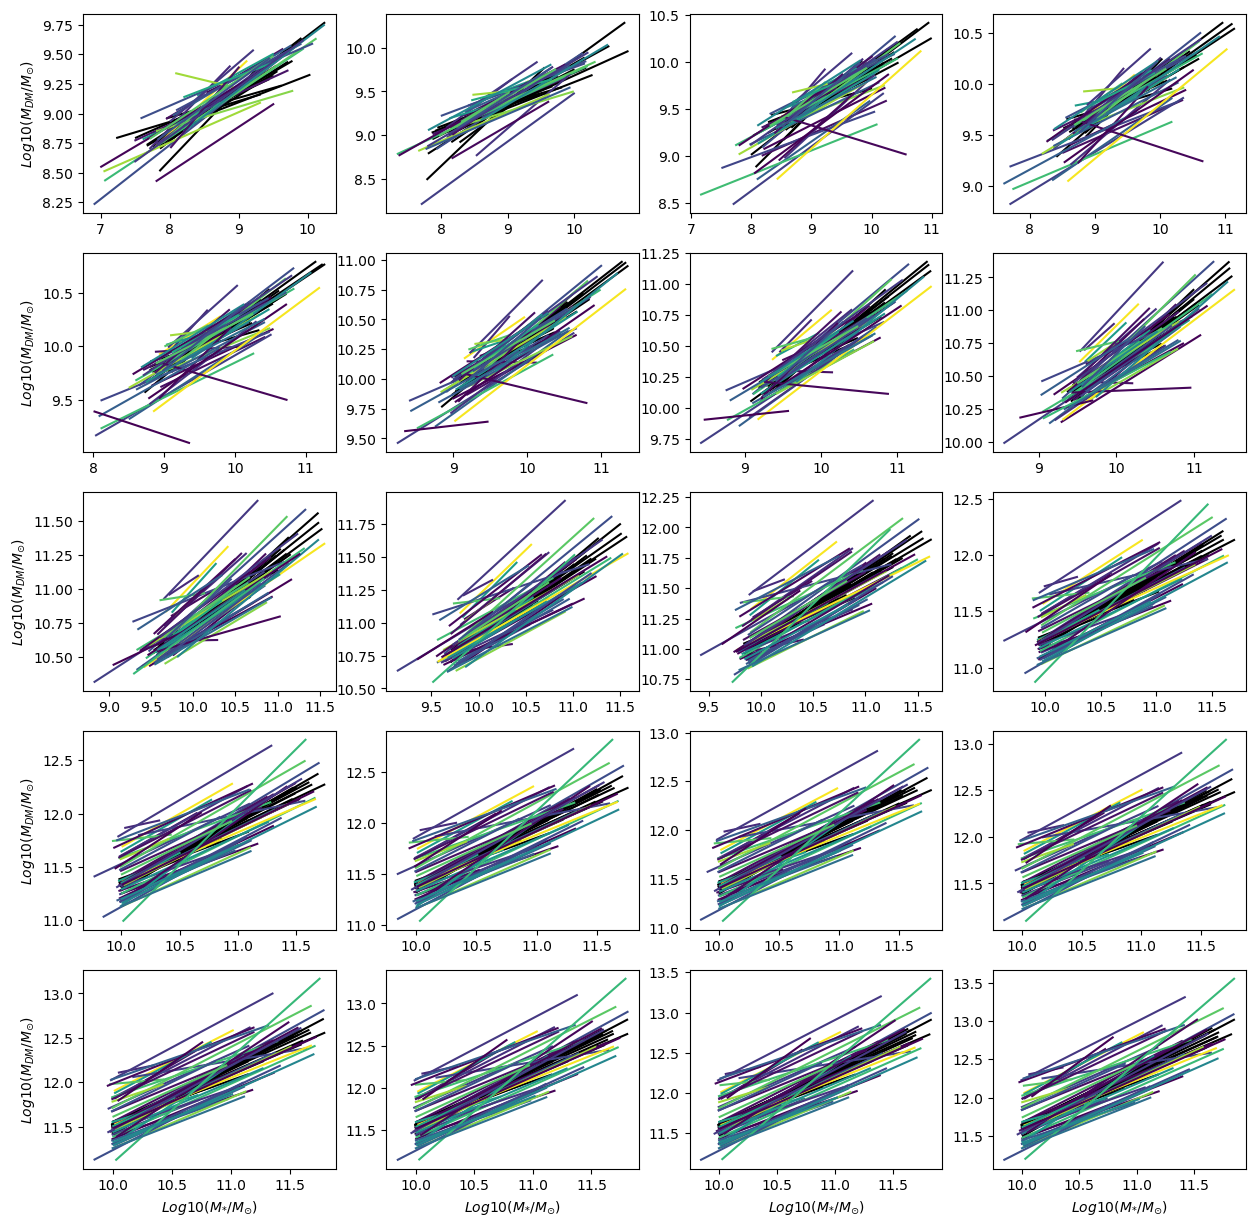

In [251]:
norm = colors.Normalize(vmin=min(pars[:,3]), vmax=max(pars[:,3]))
#norm = colors.Normalize(vmin=0, vmax=len(prof_LH))
colormap = cm.viridis  # Puedes usar otros colormaps: 'plasma', 'coolwarm', etc.


fig,ax = plt.subplots(5,4, figsize = (15,15))
axes = ax.flatten()

for isim in range(len(prof_CV)):
    for nbin in range(20):
        f = interp1d(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), fill_value=(np.log10(prof_CV[isim][:,2,nbin]).min(), np.log10(prof_CV[isim][:,2,nbin]).max()), bounds_error=False)
        coeffs = np.polyfit(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), 1) 

        #axes[nbin].scatter(np.log10(prof_CV[isim][:,0,nbin]), np.log10(prof_CV[isim][:,2,nbin]), color = 'black')
        aux = np.linspace(np.log10(prof_CV[isim][:,0,nbin]).min(), np.log10(prof_CV[isim][:,0,nbin]).max(),10)
        #axes[nbin].plot(aux, f(aux), color = 'black')
        
        y_fit = np.polyval(coeffs, aux)
        axes[nbin].plot(aux, y_fit, color = 'black')
        
        axes[nbin].set_ylabel('')
        axes[nbin].set_xlabel('')

for isim in range(len(prof_LH)):
    for nbin in range(20):
        try:
            f = interp1d(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), fill_value=(np.log10(prof_LH[isim][:,2,nbin]).min(), np.log10(prof_LH[isim][:,2,nbin]).max()), bounds_error=False)
            coeffs = np.polyfit(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), 1) 
            aux = np.linspace(np.log10(prof_LH[isim][:,0,nbin]).min(), np.log10(prof_LH[isim][:,0,nbin]).max(),10)
            
            y_fit = np.polyval(coeffs, aux)
            axes[nbin].plot(aux, y_fit, color =  colormap(norm(pars[isim,3])))
            #axes[nbin].plot(aux, f(aux), color =  colormap(norm(pars[isim,1])))
            #axes[nbin].scatter(np.log10(prof_LH[isim][:,0,nbin]), np.log10(prof_LH[isim][:,2,nbin]), color =  colormap(norm(isim)), zorder = 0)
        except:
            pass
ax[4,0].set_xlabel(r'$Log10(M_{*} / M_{\odot})$')
ax[4,1].set_xlabel(r'$Log10(M_{*} / M_{\odot})$')
ax[4,2].set_xlabel(r'$Log10(M_{*} / M_{\odot})$')
ax[4,3].set_xlabel(r'$Log10(M_{*} / M_{\odot})$')

ax[0,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')
ax[1,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')
ax[2,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')
ax[3,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')
ax[4,0].set_ylabel(r'$Log10(M_{DM} / M_{\odot})$')

In [19]:
# get the name of the snapshot and its corresponding Subfind catalog
f_snapshot = '/home/jovyan/Data/Sims/IllustrisTNG/L25n256/LH/LH_50/snapshot_090.hdf5'
f_catalog  = '/home/jovyan/Data/FOF_Subfind/IllustrisTNG/L25n256/LH/LH_50/groups_090.hdf5'

In [110]:
f = h5py.File(f_catalog, 'r')
print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


In [113]:
f['Parameters']

<HDF5 group "/Parameters" (0 members)>

In [21]:
print(f['Group'].keys(),'\n')
print(f['Subhalo'].keys())

<KeysViewHDF5 ['GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']> 

<KeysViewHDF5 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'Subhal

In [ ]:
snap = h5py.File(f_snapshot,'r')

In [75]:
snap['Header'].attrs.keys()

<KeysViewHDF5 ['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'Redshift', 'Time', 'UnitLength_in_cm', 'UnitMass_in_g', 'UnitVelocity_in_cm_per_s']>

In [84]:
BoxSize      = snap['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = snap['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = snap['Header'].attrs[u'Time']           #scale factor
h            = snap['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
mass_dm       = snap['Header'].attrs[u'MassTable'][1]*1e10/h #masses of the particles in Msun/h
Np           = snap['Header'].attrs[u'NumPart_Total']  #total number of particles for specie
Omega_m      = snap['Header'].attrs[u'Omega0']         #Omega_matter
Omega_L      = snap['Header'].attrs[u'OmegaLambda']    #Omega_baryon
print('Total number of particles in the snapshot per type',Np)

Total number of particles in the snapshot per type [15733279 16777216        0        0   644321     1680]


In [39]:
ind = np.where( (f['Subhalo']['SubhaloMassType'][()][:,4] * 1e10 / h < 1e12) & 
          (f['Subhalo']['SubhaloMassType'][()][:,4] * 1e10 / h > 1e10) &
          (f['Subhalo']['SubhaloSFR'][()] > 0.1))[0]

(array([21., 19., 17.,  4.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([10.01306343, 10.16534424, 10.31762409, 10.4699049 , 10.62218475,
        10.77446556, 10.92674637, 11.07902622, 11.23130703, 11.38358688,
        11.53586769]),
 <BarContainer object of 10 artists>)

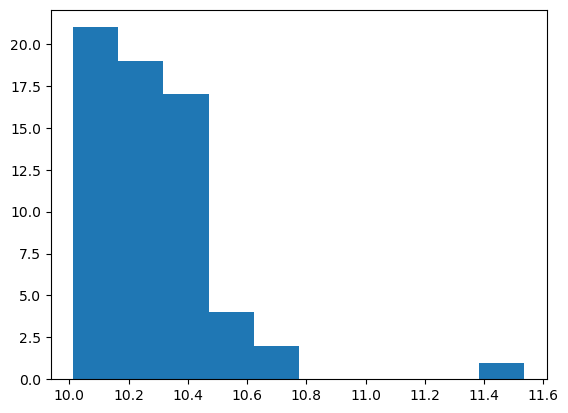

In [41]:
plt.hist(np.log10(f['Subhalo']['SubhaloMassType'][()][ind,4] * 1e10 / h))

In [5]:
# lets read the length of the FoF groups and the number of subhalos they contain
lentype_h = f['Group/GroupLenType'][:]
Nsub_h = f['Group/GroupNsubs'][:]

# for the subhalos lets read their position, mass, velocity, and SFR
pos_sh     = f['Subhalo/SubhaloPos'][:]/1e3        #Mpc/h
vel_sh     = f['Subhalo/SubhaloVel'][:]            #km/s
mass_sh    = f['Subhalo/SubhaloMassType'][:]*1e10  #Msun/h
SFR_sh     = f['Subhalo/SubhaloSFR'][:]            #Msun/yr
lentype_sh = f['Subhalo/SubhaloLenType'][:]
index_h_sh = f['Subhalo/SubhaloGrNr']

In [95]:
index_sh = ind[2]
pos_sub = pos_sh[index_sh] * 1e3 / h # kPc
vel_sub = vel_sh[index_sh]
print('position:',pos_sub,'kpc')
print('velocity:',vel_sub,'km/s')
print('mass:',mass_sh[index_sh],'Msun/h')
print('total length:',len_h[index_sh],'particles')
print('number of particles by type:',lentype_sh[index_sh])

position: [ 3791.833  25981.605   2313.8582] kpc
velocity: [ 181.98227 -181.83202  809.15234] km/s
mass: [6.4822845e+09 1.8068144e+11 0.0000000e+00 0.0000000e+00 1.3637612e+10
 3.6308956e+07] Msun/h
total length: 3180 particles
number of particles by type: [ 443 2212    0    0 1487    1]


In [7]:
len_h = f['Group/GroupLen'][:]

In [43]:
index_h = index_h_sh[index_sh] #index of the halos where this subhalo belongs to
print('This subhalo belongs to group %d'%index_h)

This subhalo belongs to group 1


In [44]:
Nsub_prev_groups = np.sum(Nsub_h[:index_h]) #This is the number of subhalos that the preceeding halos
print('The first %d halos contain %d subhalos'%(index_h,Nsub_prev_groups))

# The number of subhalos that preceed our subhalo in the halo it belongs to is
preceeding_subhalos_in_halo = index_sh - Nsub_prev_groups
print('There are %d subhalos that preceed our subhalo in the halo it belongs to'%preceeding_subhalos_in_halo)

The first 1 halos contain 327 subhalos
There are 6 subhalos that preceed our subhalo in the halo it belongs to


In [45]:
start = np.sum(lentype_h[:index_h],axis=0) + np.sum(lentype_sh[Nsub_prev_groups:index_sh],axis=0)
end = start + lentype_sh[index_sh]
print(start)
print(end)

[ 859621 1307096       0       0  104911      37]
[ 860064 1309308       0       0  106398      38]


In [94]:
pos_dm = snap['PartType1/Coordinates'][start[1]:end[1]]/h #kpc
vel_dm = snap['PartType1/Velocities'][start[1]:end[1]]      #km/s  
pos_stars = snap['PartType4/Coordinates'][start[4]:end[4]]/h #kpc
vel_stars = snap['PartType4/Velocities'][start[4]:end[4]]      #km/s
mass_stars = snap['PartType4/Masses'][start[4]:end[4]] * 1e10 / h # Msun    
pos_gas = snap['PartType0/Coordinates'][start[0]:end[0]]/h #kpc
vel_gas = snap['PartType0/Velocities'][start[0]:end[0]]      #km/s
mass_gas = snap['PartType0/Masses'][start[0]:end[0]] * 1e10 / h # Msun    
#snap.close()

In [54]:
pos_gas

array([[ 2.54451366, 17.43629051,  1.5530107 ],
       [ 2.54470762, 17.43623848,  1.55280621],
       [ 2.54451972, 17.43623967,  1.55323277],
       ...,
       [ 2.52471852, 17.44878342,  1.53556561],
       [ 2.52435523, 17.44599644,  1.5344754 ],
       [ 2.53812603, 17.42765316,  1.5339943 ]])

In [73]:
snap['PartType1'].keys()

<KeysViewHDF5 ['Coordinates', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>

In [56]:
# Let's move the coordinates if they are near the border
aux_ind = np.where( (pos_stars[:, 0] - pos_sub[0]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 0] = pos_stars[aux_ind, 0] - BoxSize
aux_ind = np.where( (pos_sub[0] - pos_stars[:, 0]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 0] = pos_stars[aux_ind, 0] + BoxSize
aux_ind = np.where( (pos_stars[:, 1] - pos_sub[1]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 1] = pos_stars[aux_ind, 1] - BoxSize
aux_ind = np.where( (pos_sub[1] - pos_stars[:, 1]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 1] = pos_stars[aux_ind, 1] + BoxSize
aux_ind = np.where( (pos_stars[:, 2] - pos_sub[2]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 2] = pos_stars[aux_ind, 2] - BoxSize
aux_ind = np.where( (pos_sub[2] - pos_stars[:, 2]) > (BoxSize / 2) )[0]
pos_stars[aux_ind, 2] = pos_stars[aux_ind, 2] + BoxSize
                

In [97]:
 # ------------------Let's center the particles -----------
pos_stars = pos_stars - pos_sub
vel_stars = vel_stars - vel_sub

vel_dm = vel_dm - vel_sub
pos_dm = pos_dm - pos_sub

pos_gas = pos_gas - pos_sub
vel_gas = vel_gas - vel_sub

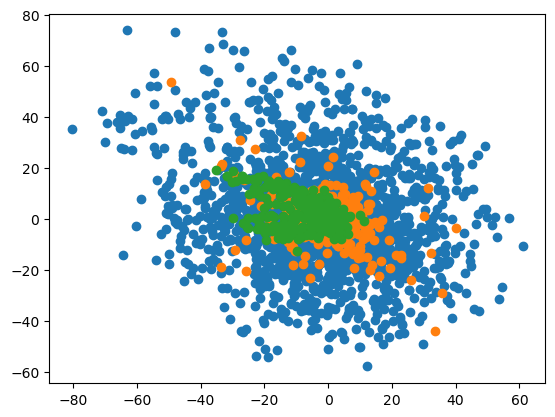

In [98]:
plt.scatter(pos_dm[:,0], pos_dm[:,1])
plt.scatter(pos_stars[:,0], pos_stars[:,1])
plt.scatter(pos_gas[:,0], pos_gas[:,1])
#plt.scatter(pos_sh[index_sh][0], pos_sh[index_sh][1], marker = '*', color = 'red')

In [99]:
R_bins = np.geomspace(1,100,20)

dist = np.linalg.norm(pos_stars, axis=1)
M_stars = np.array([np.sum( mass_stars[np.where(np.array(dist) < R)[0]] ) for R in R_bins])

dist = np.linalg.norm(pos_gas, axis=1)
M_gas = np.array([np.sum( mass_gas[np.where(np.array(dist) < R)[0]] ) for R in R_bins])

dist = np.linalg.norm(pos_dm, axis=1)
M_dm = np.array([mass_dm * len(np.where(np.array(dist) < R)[0]) for R in R_bins])

In [91]:
R_bins

array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ])

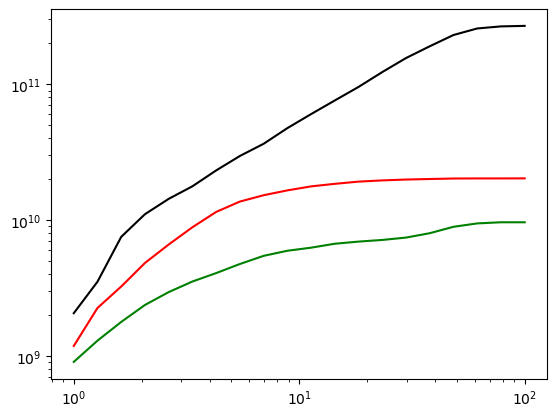

In [101]:
plt.plot(R_bins, M_dm, color = 'black')
plt.plot(R_bins, M_stars, color = 'red')
plt.plot(R_bins, M_gas, color = 'green')
plt.yscale('log')
plt.xscale('log')